In [1]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import sklearn
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


## Read in Data

In [2]:
## Read in Sequence Data

# Raw Data
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv',index_col=0)
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# Calculated MFEs
mfe_df = pd.read_csv('./saved_data/positional_mfe.csv')
mfe_arr = mfe_df.values
df['positional_mfe'] = list(mfe_arr[:,1:51])


# Scale the training mean ribosome load values and positional MFEs
df['scaled_rl'] = preprocessing.StandardScaler().fit_transform(df['rl'].values.reshape(-1,1))
df['scaled_mfe'] = list(preprocessing.StandardScaler().fit_transform(mfe_arr[:,1:51]))

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# Label the datasets
e_train.loc[:,'dataset'] = 'train'
e_test.loc[:,'dataset'] = 'test'

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Training and Testing Functions

In [1]:
def train_model(x, y, border_mode='same', inp_len=50, input_features=5, layers=3, filter_len=8, nbr_filters=120,
                nb_epoch=3, nodes=40, dense_dropout=0.2,random_seed_value=1337):
    ''' Build model archicture and fit.'''
    np.random.seed(random_seed_value)
    model = Sequential()
    model.add(Conv1D(activation="relu", input_shape=(inp_len, input_features),
                     padding=border_mode, filters=nbr_filters,kernel_size=filter_len))
    
    for i in range(1,layers):
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1),
                         padding=border_mode, filters=nbr_filters, 
                         kernel_size=filter_len ))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dense_dropout))

    model.add(Dense(1))
    model.add(Activation('linear'))
        
    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale to the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def test_binary_data(df, model, test_seq, obs_col, output_col='pred'):
    # No need to reshape since values already are all 0 or 1
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = predictions
    df.loc[:,output_col+'_error'] = df[obs_col] - df[output_col]
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def sequence_encode(df, seq_col='utr', n_col='scaled_mfe', seq_len=50):
    """Combines one-hot encoding with a sequential numerical features from the specified other column"""
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,5])
    
    # Iterate through UTRs and one-hot encode
    seqs = df[seq_col].str[:seq_len]
    vals = df[n_col].values
    for i,(seq,val) in enumerate(zip(seqs,vals)): 
        for j,(s,v) in enumerate(zip(seq,val)):
            vectors[i][j][0:4] = nuc_d[s]
            vectors[i][j][4] = v
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

get_mfe = lambda s: RNA.fold(s)[1] #check if this should be fold or LFold !!!
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"
HEADER_LEN = len(upstream_constant)

def positional_mfe(seq,index,span):
    subseq = seq[index-(span/2):index+(span/2)+1]
    return get_mfe(subseq)

# WARNING: computationally intensive for large numbers of sequences!!
def mfe_encode(df, col='utr', seq_len=50, span=40): #WARNING: spans over ~50 overflow upstream!
    vectors=np.empty([len(df),seq_len])
    for i,seq in enumerate(df[col].str[:seq_len]): 
        s = upstream_constant+seq+eGFP
        # Calculate MFE at every position
        a = np.array([ positional_mfe(s,s_ind,span) for s_ind in np.arange(HEADER_LEN,seq_len+HEADER_LEN) ])
        vectors[i] = a
        if (i+1) % 1000 == 0:
            print i+1
    return vectors 

In [2]:
# One-hot encode both training and test UTRs
seq_e_train = sequence_encode(e_train,seq_len=50)
seq_e_test = sequence_encode(e_test, seq_len=50)

# Labels
scaled_train_labels = e_train['scaled_rl'].values

NameError: name 'e_train' is not defined

## Create and Train Models

In [3]:
# Small Model
small_model = train_model(seq_e_train,scaled_train_labels,layers=3,filter_len=7,nbr_filters=10,
                          nodes=20,dense_dropout=0.0,nb_epoch=5)

NameError: name 'seq_e_train' is not defined

In [68]:
e_train = test_data(df=e_train,model=small_model,test_seq=seq_e_train,obs_col='rl',output_col='small_pred')
e_test = test_data(df=e_test,model=small_model,test_seq=seq_e_test,obs_col='rl',output_col='small_pred')

print 'Small Train R2:', r2(e_train['rl'],e_train['small_pred'])
print 'Small Test R2:', r2(e_test['rl'],e_test['small_pred'])

Small Train R2: 0.8735438206956447
Small Test R2: 0.921391762838034


In [69]:
# Medium Model
medium_model = train_model(seq_e_train,scaled_train_labels,layers=6,filter_len=7,nbr_filters=15,
                          nodes=40,dense_dropout=0.0,nb_epoch=6)

Epoch 1/6
260000/260000 [==============================] - 33s 128us/step - loss: 0.2927
Epoch 2/6
260000/260000 [==============================] - 32s 122us/step - loss: 0.1404
Epoch 3/6
260000/260000 [==============================] - 32s 122us/step - loss: 0.1165
Epoch 4/6
260000/260000 [==============================] - 32s 125us/step - loss: 0.1112
Epoch 5/6
260000/260000 [==============================] - 35s 134us/step - loss: 0.1072
Epoch 6/6
260000/260000 [==============================] - 34s 131us/step - loss: 0.1055


In [70]:
e_train = test_data(df=e_train,model=medium_model,test_seq=seq_e_train,obs_col='rl',output_col='medium_pred')
e_test = test_data(df=e_test,model=medium_model,test_seq=seq_e_test,obs_col='rl',output_col='medium_pred')

print 'Medium Train R2:', r2(e_train['rl'],e_train['medium_pred'])
print 'Medium Test R2:', r2(e_test['rl'],e_test['medium_pred'])

Medium Train R2: 0.8949799472162581
Medium Test R2: 0.9393383257854083


In [97]:
# Large Model
large_model = train_model(seq_e_train,scaled_train_labels,layers=6,filter_len=7,nbr_filters=40,
                          nodes=40,dense_dropout=0.0,nb_epoch=6)

Epoch 1/6
260000/260000 [==============================] - 74s 285us/step - loss: 0.2376
Epoch 2/6
260000/260000 [==============================] - 71s 274us/step - loss: 0.1146
Epoch 3/6
260000/260000 [==============================] - 75s 288us/step - loss: 0.1063
Epoch 4/6
260000/260000 [==============================] - 73s 279us/step - loss: 0.1020
Epoch 5/6
260000/260000 [==============================] - 73s 280us/step - loss: 0.0986
Epoch 6/6
260000/260000 [==============================] - 73s 282us/step - loss: 0.0964


In [ ]:
e_train = test_data(df=e_train,model=large_model,test_seq=seq_e_train,obs_col='rl',output_col='large_pred')
e_test = test_data(df=e_test,model=large_model,test_seq=seq_e_test,obs_col='rl',output_col='large_pred')

print 'Large Train R2:', r2(e_train['rl'],e_train['large_pred'])
print 'Large Test R2:', r2(e_test['rl'],e_test['large_pred'])

## Visualize Model Performance

In [32]:
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred',xaxislabel='Observed MRL',yaxislabel="Predicted MRL"):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, height=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels(xaxislabel, yaxislabel, **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

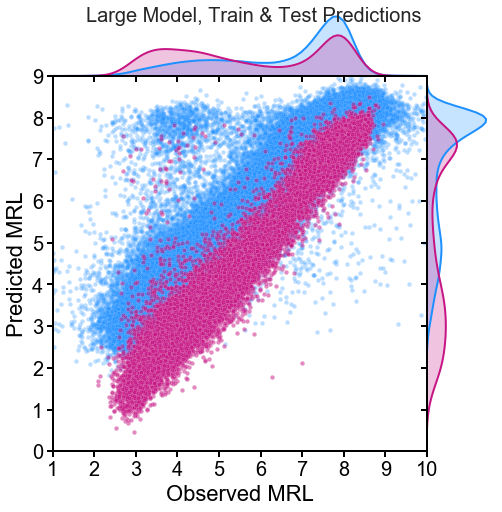

In [89]:
plot_large = jointgrid_plot([e_train,e_test],alphas=[0.3,0.5],yheader='large_pred',colors=['dodgerblue','mediumvioletred'],
                           title="Large Model, Train & Test Predictions")

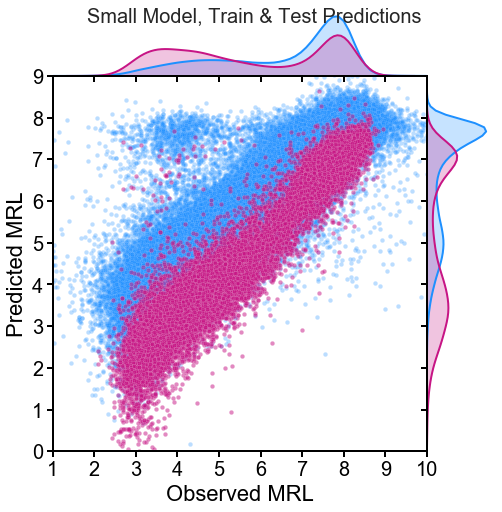

In [33]:
plot_small = jointgrid_plot([e_train,e_test],alphas=[0.3,0.5],yheader='small_pred',colors=['dodgerblue','mediumvioletred'],
                           title="Small Model, Train & Test Predictions")

In [90]:
data = pd.concat([e_train,e_test],axis=0,sort=True)
ofd = data[((data['large_pred']-data['rl'])**2 > 3.5)
                  &(data['large_pred']-data['rl'] > 0)
                  &(data['large_pred'] > 6.5)] 
ond = data[~data['utr'].isin(ofd['utr'].values)]
print len(ofd), len(ond), len(ofd[ofd['dataset'] == 'test'])
data.loc[:,'off_diagonal'] = [ s in ofd['utr'].values for s in data['utr'].values ]

1336 278664 38


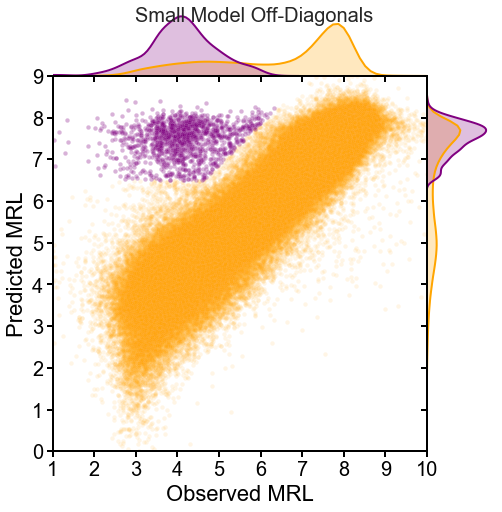

In [37]:
plot_small2 = jointgrid_plot([ond,ofd],alphas=[0.1,0.3],yheader='small_pred',
                            colors = ['orange','purple'],
                            title="Large Model Off-Diagonals")